# Neural Networks for Data Science Applications
## Lab session 5: Building CNNs from scratch

**Contents of the lab session:**
+ Build flexible image pipelines in TF using tf.data.
+ Defining a CNN architecture from scratch.
+ Make code faster using `tf.function`.

In [1]:
# Remember to enable a GPU on Colab by:
# Runtime >> Change runtime type >> Hardware accelerator (before starting the VM).
!pip install -q tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 44kB/s 
     |████████████████████████████████| 3.8MB 44.3MB/s 
     |████████████████████████████████| 450kB 45.4MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.


## About the task for this lab session

The data can be downloaded as **Dataset 1** from here:
https://github.com/SullyChen/driving-datasets

Direct Drive link:
https://drive.google.com/file/d/0B-KJCaaF7elleG1RbzVPZWV4Tlk/view?usp=sharing

For each image (taken from a front-facing camera in a car), we want to predict the steering direction.)

### Step 0 (ONLY COLAB): Load the Drive file
This part is only needed in a Colab environment for downloading the Drive file.

*Note*: the download code can be found in Colab from the left menu, under Code Snippets.

In [0]:
# After this, restart the runtime to avoid authentication issues
!pip install -q -U PyDrive

In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Download the file based on its file ID.
# https://drive.google.com/file/d/0B-KJCaaF7elleG1RbzVPZWV4Tlk/view
file_id = '0B-KJCaaF7elleG1RbzVPZWV4Tlk'
downloaded = drive.CreateFile({'id': file_id})

In [0]:
downloaded.GetContentFile('driving_dataset.zip')

In [0]:
!unzip -q driving_dataset.zip

In [0]:
# Explore the content! (Also from the left menu.)
# You can see that image information is provided in a single .txt file,
# making difficult the use of the ImageDataGenerator from tf.keras. 
# For this reason, we'll make a more flexible pipeline with tf.data.
!ls driving_dataset

### Step 1: Load the CSV file

In [0]:
import pandas as pd
files = pd.read_csv('driving_dataset/data.txt', 
                    header=None, sep=' ')

In [8]:
# First column is the file name, second column is the steering angle
files.head()

,0,1
0,0.jpg,0.0
1,1.jpg,0.0
2,2.jpg,0.0
3,3.jpg,0.0
4,4.jpg,0.0


In [0]:
paths = files.iloc[:, 0]
labels = files.iloc[:, 1]

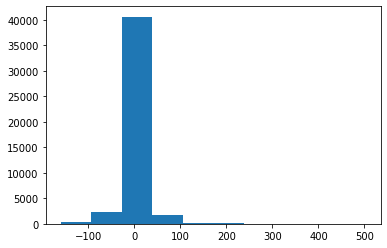

In [10]:
# Plot the distribution of labels (note some form of unbalance)
import matplotlib.pyplot as plt
_ = plt.hist(labels)

In [0]:
# Some angles are definitely strange, we'll remove them
good_idx = labels < 180

In [0]:
paths = paths.loc[good_idx]
labels = labels.loc[good_idx]

In [13]:
paths.shape

(45187,)

### Step 2: Define the tf.data pipeline

We could also use the Keras interface `flow_from_dataframe`, but because our data preprocessing pipeline is more complicated this time, we show how to do it entirely using the 'tf.data' module.

A full guide can be found here: https://www.tensorflow.org/tutorials/load_data/images

In [0]:
import tensorflow as tf

In [0]:
paths = tf.constant(paths.values)
labels = tf.constant(labels.values)

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((paths, labels))

In [35]:
for xb, yb in dataset.batch(4).take(1):
  print(xb)
  print(yb)

tf.Tensor([b'0.jpg' b'1.jpg' b'2.jpg' b'3.jpg'], shape=(4,), dtype=string)
tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float64)


In [0]:
# Preprocess the dataset in order to load each image:
# After applying this function, each pair (path, label) is converted to (image, label)
def preprocess(path, label):
  
  full_path = './driving_dataset' + '/' + path # This is the actual path
  image = tf.io.read_file(full_path)
  image = tf.io.decode_image(image, channels=3) # We specify the number of channels to avoid b/w images having just one channel
  image = tf.image.resize_with_crop_or_pad(image, 196, 455) # We crop or pad to a specific dimension
  image = tf.cast(image, tf.float32) / 255.0 # Normalize the image to [0.0, 1.0]

  label = label / 180.0 # We also normalize the label to [-1.0, 1.0]
  return image, label

In [0]:
def augment(image, label):
  # Another preprocessing function to randomly change the brightness of the input images
  image = tf.image.random_brightness(image, 0.05)
  return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([0.], shape=(1,), dtype=float64)


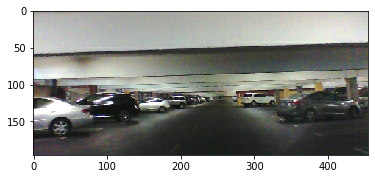

In [60]:
import matplotlib.pyplot as plt
# Try the full pipeline
for xb, yb in dataset.map(preprocess).map(augment).batch(1).take(1):
  plt.imshow(xb[0].numpy())
  print(yb)

In [0]:
# Split the dataset
test_dataset = dataset.take(5000)
train_dataset = dataset.skip(5000)

In [0]:
# Setup the train / test iterators
train_dataset = train_dataset.map(preprocess).map(augment).shuffle(1000).batch(32)
test_dataset = test_dataset.map(preprocess).batch(32)

### Step 3: Define our convolutional architecture

In [0]:
from tensorflow.keras import Model
from tensorflow.keras import layers, regularizers, initializers

In [0]:
images = layers.Input(shape=(196, 455, 3))

In [0]:
def add_block(x, n_filters, strides=2):
    # Convolutional block with custom initialization and regularization
    x = layers.Conv2D(n_filters, 5, padding='same', strides=strides, 
                      kernel_regularizer=regularizers.l2(0.001),
                      kernel_initializer=initializers.glorot_normal)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

In [0]:
x = add_block(images, 32)

In [0]:
n_blocks = 3
for i in range(1, n_blocks + 1):
  x = add_block(x, 64 * i)
  # TODO: experiment adding more blocks and residual connections
  #x = add_block(x, 64 * i, strides=1) + x

In [0]:
# Final part with regression block
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(50, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='tanh')(x) # The tanh ensures the outputs are properly normalized in [-1.0, 1.0]

In [0]:
net = Model(inputs=[images], outputs=[x])

In [97]:
net.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 196, 455, 3)]     0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 98, 228, 32)       2432      
_________________________________________________________________
batch_normalization_22 (Batc (None, 98, 228, 32)       128       
_________________________________________________________________
activation_22 (Activation)   (None, 98, 228, 32)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 49, 114, 64)       51264     
_________________________________________________________________
batch_normalization_23 (Batc (None, 49, 114, 64)       256       
_________________________________________________________________
activation_23 (Activation)   (None, 49, 114, 64)       0   

In [98]:
# When we enable training, the output changes every single time
net(xb, training=True)

<tf.Tensor: id=30887, shape=(1, 1), dtype=float32, numpy=array([[0.95246494]], dtype=float32)>

### Step 4: Train the model

In [0]:
from tensorflow.keras import losses, optimizers, metrics

In [0]:
# Because this is a regression task, we select the mean-squared error as loss function
net.compile(loss=losses.MeanSquaredError(), optimizer=optimizers.RMSprop(0.001))

In [101]:
history = net.fit(train_dataset, epochs=2)

Epoch 1/2
1256/1256 [==============================] - 218s 173ms/step - loss: 0.5389
Epoch 2/2
1256/1256 [==============================] - 214s 171ms/step - loss: 0.0196


In [104]:
# Test the final error
net.evaluate(test_dataset)

157/157 [==============================] - 16s 100ms/step - loss: 0.0294


0.029351789060873306

### Step 5: Make inference faster with tf.function

In [0]:
#@tf.function
def predict(x):
  return net(x, training=False)

In [0]:
for xb, _ in test_dataset.take(1):
  _

In [111]:
# See the difference with and without tf.function
%timeit -r 10 -n 5 predict(xb)

5 loops, best of 10: 34.2 ms per loop


**TODO**
+ Experiment with different architectures! Remove the residual connections, add more blocks...
+ Play with different data augmentation strategies.
+ Try to visualize the results on different images.
+ Also test with different optimizers: in this example we have used RMSProp because it seems to work better, but you can try fine-tuning other optimizers.
+ You can also try a simplified classification problem with {go left, go straight, go right}.